# Strategy Diagnosis & Visualization

This notebook provides a deep dive into the strategy's performance, regime detection, and risk metrics. 
It uses the Phase 6 Backtesting Engine and Phase 5 Risk Management components.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path to import src
sys.path.append(os.path.abspath('..'))

from src.features.builder import build_features
from src.regimes.inference import rolling_inference
from src.backtest.engine import BacktestEngine
from src.strategies.robust import RobustTrendStrategy
from src.risk.sizing import apply_vol_targeting
from src.risk.limits import RiskLimits

%matplotlib inline
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)

## 1. Load Data & Build Features

In [2]:
data_path = '../data/raw/btc_4h.csv'
print(f"Loading data from {data_path}...")
df = pd.read_csv(data_path, parse_dates=['timestamp'])
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)

print("Building features...")
features = build_features(df)
features.dropna(inplace=True)
df = df.loc[features.index]

Loading data from ../data/raw/btc_4h.csv...
Building features...


## 2. Regime Detection (Rolling Inference)

In [3]:
print("Running rolling regime inference... (This may take a minute)")
regime_df = rolling_inference(features, window=1000, refit_interval=100, n_components=3, sort_by='rolling_std_medium')
df = df.join(regime_df)

print("Regime distribution:")
print(df['regime'].value_counts(normalize=True))

Running rolling regime inference... (This may take a minute)


Rolling Inference: 100%|██████████| 9824/9824 [00:17<00:00, 572.67it/s]

Regime distribution:
regime
1.0    0.405334
0.0    0.304560
2.0    0.290106
Name: proportion, dtype: float64


## 3. Strategy Execution

**Logic:**
- **Regime 0 (Low Vol / Noise):** Flat (Cash + Yield)
- **Regime 1 (Med Vol / Chop):** Flat (Cash + Yield)
- **Regime 2 (High Vol / Trend):** Robust Trend Strategy (EMA Cross + ADX Filter)

In [4]:
# Instantiate Strategy for Regime 2
s_trend_r2 = RobustTrendStrategy(
    fast_span=20, 
    slow_span=50, 
    adx_threshold=30.0,
    trend_regime=2,
    long_only=False  # Allow shorts in high vol if trend confirms, or set True if desired
)

# Debug: Check columns
print(f"Columns available: {df.columns.tolist()}")
if 'close' not in df.columns:
    print("Error: 'close' column missing. Attempting to restore from original file...")
    # Fallback: Reload close price and join by index
    df_raw = pd.read_csv('../data/raw/btc_4h.csv', parse_dates=['timestamp'])
    df_raw.sort_values('timestamp', inplace=True)
    df_raw.reset_index(drop=True, inplace=True)
    # We need to match the index of current df
    # Assuming current df index corresponds to original raw index (which it should if we only sliced)
    df['close'] = df_raw.loc[df.index, 'close']
    df['timestamp'] = df_raw.loc[df.index, 'timestamp']
    print("Restored 'close' and 'timestamp' columns.")

# Generate Signals (Pass regime series explicitly)
sig_trend = s_trend_r2.generate_signals(df, df['regime'])

# Combine: Only trade in Regime 2
# (The strategy class already filters by trend_regime=2, but explicitly:)
sig_comp = sig_trend.fillna(0.0)

# Apply Volatility Targeting
print("Applying Volatility Targeting (Target 60% Annualized)...")
sig_vol = apply_vol_targeting(
    sig_comp, 
    df['close'], 
    target_annual_vol=0.60,
    max_leverage=3.0
)

# Apply Hard Risk Limits
risk_limits = RiskLimits(max_leverage=3.0, max_position_size=3.0)
sig_final = risk_limits.apply_limits(sig_vol)

Columns available: ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'regime', 'regime_proba_0', 'regime_proba_1', 'regime_proba_2']
Applying Volatility Targeting (Target 60% Annualized)...


## 4. Backtest (Phase 6 Engine)

In [5]:
backtester = BacktestEngine(
    initial_capital=10000.0, 
    fee_rate=0.0005,
    idle_apy=0.06  # 6% Yield on idle cash
)

print("Running backtest...")
results = backtester.run(df, sig_final)
metrics = results['metrics']

print("\n=== Performance Metrics ===")
print(f"Total Return: {metrics['total_return']*100:.2f}%")
print(f"CAGR:         {metrics['cagr']*100:.2f}%")
print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {metrics['max_drawdown']*100:.2f}%")

Running backtest...

=== Performance Metrics ===
Total Return: 246.53%
CAGR:         28.59%
Sharpe Ratio: 1.21
Max Drawdown: -21.39%


In [6]:
# --- Storytelling Metrics ---
data = results['data'].copy()

# 1. % Time in Market
time_in_market = (data['signal'].abs() > 0).mean()
time_in_cash = 1.0 - time_in_market

# 2. Return Contributions
# Strategy Return (BTC Exposure) vs Yield
data['log_ret_strat'] = np.log1p(data['strategy_returns'])
data['log_ret_yield'] = np.log1p(data['yield_returns'])
total_log_ret_strat = data['log_ret_strat'].sum()
total_log_ret_yield = data['log_ret_yield'].sum()

ret_strat_only = np.exp(total_log_ret_strat) - 1
ret_yield_only = np.exp(total_log_ret_yield) - 1

# 3. Worst BTC-only Drawdown
strat_equity_curve = (1 + data['strategy_returns']).cumprod()
strat_peak = strat_equity_curve.cummax()
strat_drawdown = (strat_equity_curve - strat_peak) / strat_peak
max_strat_dd = strat_drawdown.min()

# 4. Performance during BTC Crashes
# Identify "Crash" periods: Where Buy & Hold Drawdown < -20%
bh_equity = (1 + data['returns']).cumprod()
bh_peak = bh_equity.cummax()
bh_drawdown = (bh_equity - bh_peak) / bh_peak

crash_mask = bh_drawdown < -0.20
crash_log_ret_strat = np.log1p(data['net_returns'][crash_mask]).sum()
crash_ret_strat = np.exp(crash_log_ret_strat) - 1

crash_log_ret_btc = np.log1p(data['returns'][crash_mask]).sum()
crash_ret_btc = np.exp(crash_log_ret_btc) - 1

print("\n=== Storytelling Metrics ===")
print(f"Time in Market (BTC):    {time_in_market*100:.1f}%")
print(f"Time in Cash (Stable):   {time_in_cash*100:.1f}%")
print("-" * 30)
print(f"Return from BTC Trades:  {ret_strat_only*100:.1f}% (approx)")
print(f"Return from Yield:       {ret_yield_only*100:.1f}% (approx)")
print("-" * 30)
print(f"Worst BTC-only Drawdown: {max_strat_dd*100:.2f}%")
print(f"Max Strategy Drawdown:   {metrics['max_drawdown']*100:.2f}% (Total Equity)")
print("-" * 30)
print(f"During BTC 'Crashes' (Drawdown < -20%):")
print(f"  BTC Return:            {crash_ret_btc*100:.2f}%")
print(f"  Strategy Return:       {crash_ret_strat*100:.2f}%")


=== Storytelling Metrics ===
Time in Market (BTC):    8.6%
Time in Cash (Stable):   91.4%
------------------------------
Return from BTC Trades:  202.7% (approx)
Return from Yield:       30.3% (approx)
------------------------------
Worst BTC-only Drawdown: -23.10%
Max Strategy Drawdown:   -21.39% (Total Equity)
------------------------------
During BTC 'Crashes' (Drawdown < -20%):
  BTC Return:            -70.96%
  Strategy Return:       285.99%


## 5. Visualizations

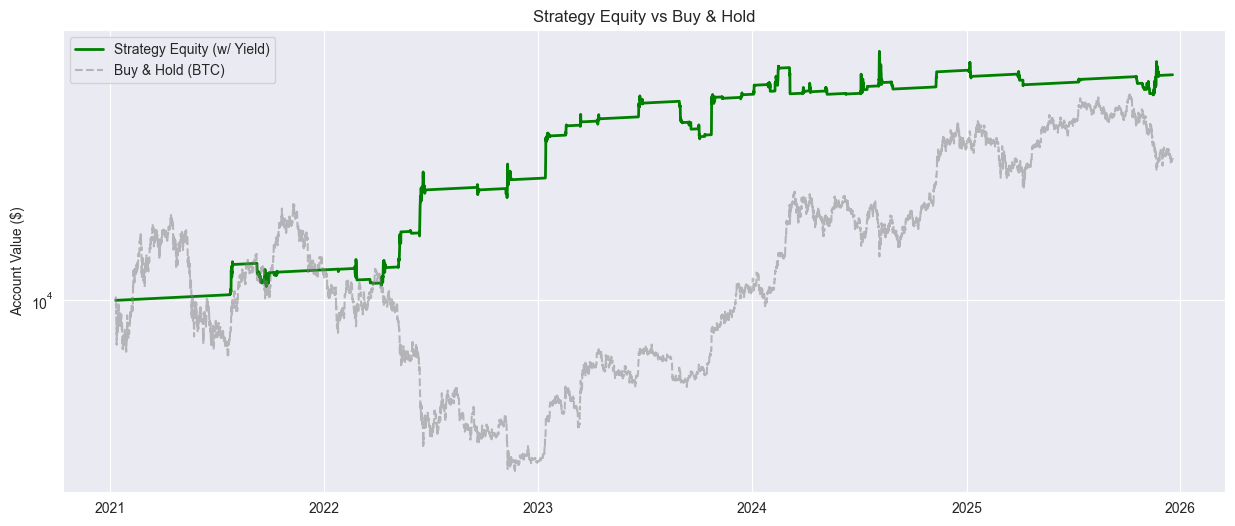

In [7]:
equity = results['data']['equity']
df_res = df.iloc[-len(equity):].copy()
df_res['equity'] = equity
df_res['drawdown'] = (df_res['equity'] - df_res['equity'].cummax()) / df_res['equity'].cummax()
df_res['buy_hold_norm'] = (df_res['close'] / df_res['close'].iloc[0]) * 10000

# Plot 1: Equity Curve vs Buy & Hold
plt.figure(figsize=(15, 6))
plt.plot(df_res['timestamp'], df_res['equity'], label='Strategy Equity (w/ Yield)', color='green', linewidth=2)
plt.plot(df_res['timestamp'], df_res['buy_hold_norm'], label='Buy & Hold (BTC)', color='gray', alpha=0.5, linestyle='--')
plt.title('Strategy Equity vs Buy & Hold')
plt.yscale('log')
plt.legend()
plt.ylabel('Account Value ($)')
plt.show()

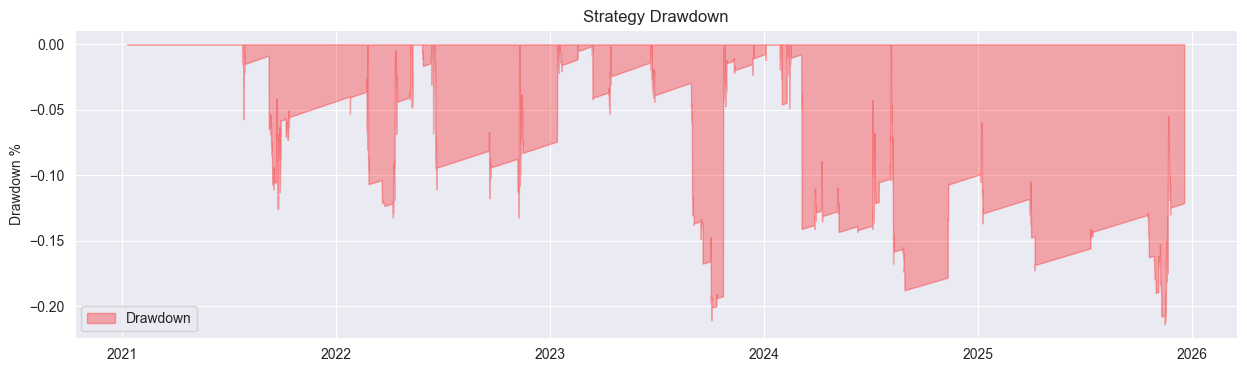

In [8]:
# Plot 2: Drawdowns
plt.figure(figsize=(15, 4))
plt.fill_between(df_res['timestamp'], df_res['drawdown'], 0, color='red', alpha=0.3, label='Drawdown')
plt.title('Strategy Drawdown')
plt.ylabel('Drawdown %')
plt.legend()
plt.show()

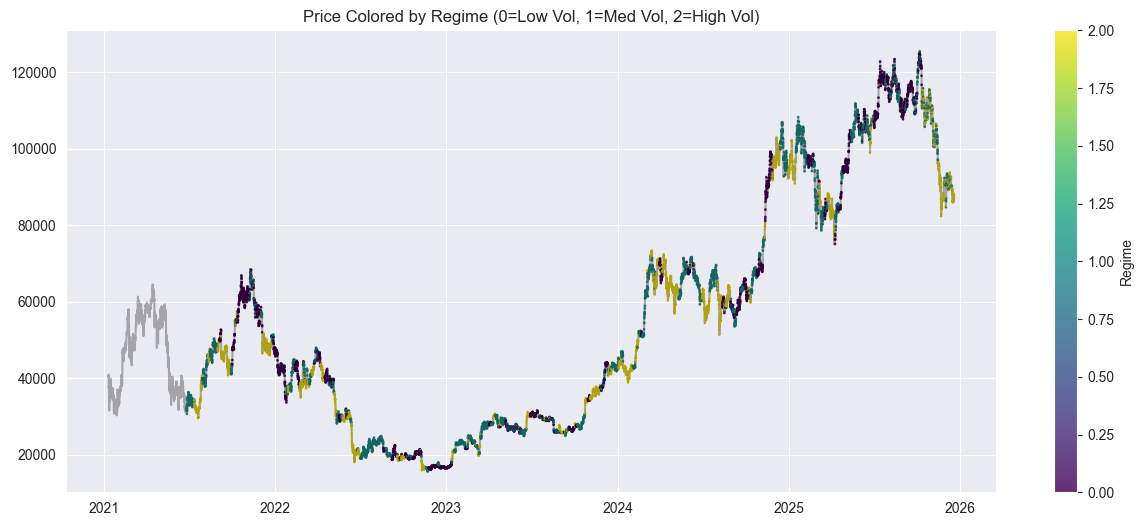

In [9]:
# Plot 3: Regime Map
plt.figure(figsize=(15, 6))
plt.plot(df_res['timestamp'], df_res['close'], color='black', alpha=0.3)
scatter = plt.scatter(df_res['timestamp'], df_res['close'], c=df_res['regime'], cmap='viridis', s=1, alpha=0.8)
plt.title('Price Colored by Regime (0=Low Vol, 1=Med Vol, 2=High Vol)')
plt.colorbar(scatter, label='Regime')
plt.show()

/var/folders/b6/bn0gvxxs34qd11xzptp2ftlw0000gn/T/ipykernel_95151/3191093252.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['log_ret'] = np.log(subset['close'] / subset['close'].shift(1))
/var/folders/b6/bn0gvxxs34qd11xzptp2ftlw0000gn/T/ipykernel_95151/3191093252.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['log_ret'] = np.log(subset['close'] / subset['close'].shift(1))
/var/folders/b6/bn0gvxxs34qd11xzptp2ftlw0000gn/T/ipykernel_95151/3191093252.py:13: SettingWithCopyWarning: 
A va

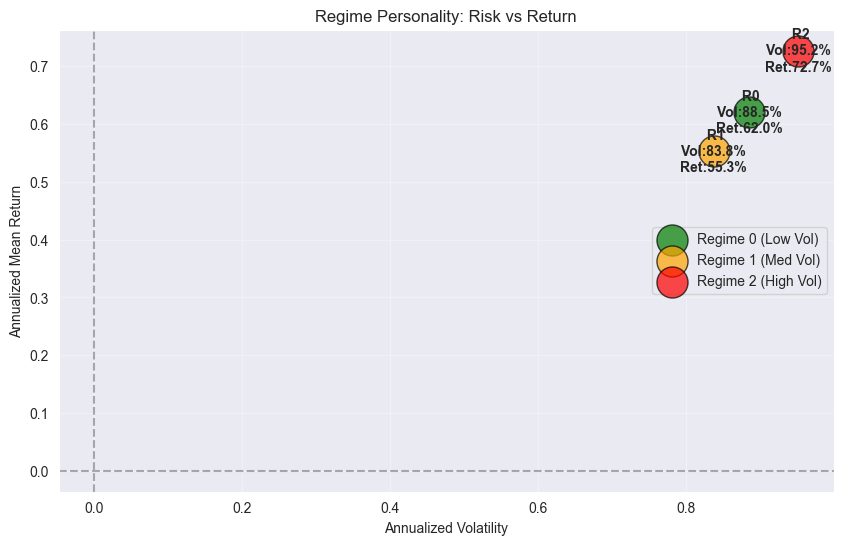

In [10]:
# Plot 4: Regime Personality Test
plt.figure(figsize=(10, 6))

colors = ['green', 'orange', 'red']
labels = ['Regime 0 (Low Vol)', 'Regime 1 (Med Vol)', 'Regime 2 (High Vol)']

for r in [0, 1, 2]:
    subset = df_res[df_res['regime'] == r]
    if len(subset) == 0: continue
    
    # We use 'log_ret' (if avail) or calculate it
    if 'log_ret' not in subset.columns:
        subset['log_ret'] = np.log(subset['close'] / subset['close'].shift(1))
    
    # Calculate Volatility (std of returns) and Mean Return
    vol = subset['log_ret'].std() * np.sqrt(6*365) # Annualized
    mean_ret = subset['log_ret'].mean() * 6*365    # Annualized
    
    plt.scatter(vol, mean_ret, s=500, c=colors[r], label=labels[r], alpha=0.7, edgecolors='black')
    plt.text(vol, mean_ret, f" R{r}\nVol:{vol:.1%}\nRet:{mean_ret:.1%}", 
             ha='center', va='center', fontweight='bold')

plt.title('Regime Personality: Risk vs Return')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Mean Return')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

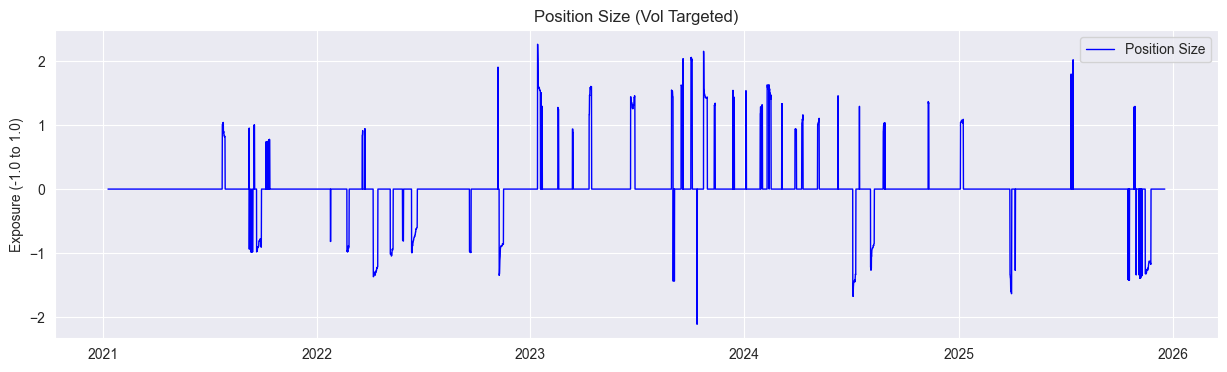

In [11]:
# Plot 4: Position Size Over Time
plt.figure(figsize=(15, 4))
plt.plot(df_res['timestamp'], sig_final.iloc[-len(df_res):], label='Position Size', color='blue', linewidth=1)
plt.title('Position Size (Vol Targeted)')
plt.ylabel('Exposure (-1.0 to 1.0)')
plt.legend()
plt.show()